**UNFINISHED** (also old)

Notebook for the engineering team to use to calculate x and y for the arm (x is part of the arm between servos at alpha and beta, y is between beta and the grabber).

max_range -> returns the maximum range the arm can extend to with the given values for x and y and constrained to 20 <= alpha <= 90 (degrees)
beta_clockwise_moments -> returns the net clockwise moment acting on the servo at beta
alpha_clockwise_moments -> returns the net clockwise moment acting on the servo at alpha

check_lengths -> checks the above three functions return answers that would mean the arm can attain sufficient range within the bounds of alpha and beta.

apologies for the horrbile alpha_clockwise_moments function, but i tried to keep the function formatted the same as the equation sent on discord

**Notes:**
Gradient ascent being used for finding the range has to check a lot of alpha values, so it there is an alpha value available in which it is not possible to touch the table then a complex number will be returned and we'll get an error. We want to be able to touch the table for all values of alpha in the range, so we know that the values for x and y are invalid if it crashes.

There is an issue with antclockwise moments which is going to be a little more tricky. Will investigate further later.

In [ ]:
from math import cos, sin, atan, pi, radians  # all angles in radians
from itertools import product

In [ ]:
def max_range(x, y, iterations=20, eta=0.1):  # eta is like learning rate
  get_range = lambda alpha, x, y : x * cos(alpha) + (y**2 - (0.1 - x*sin(alpha))**2)**0.5  # if we want to speed this up we can do it algerbraically, but this is more versatile imo
  get_range_grad = lambda alpha, x, y : ( (x * cos(alpha)) * (0.1 - x * sin(alpha)) )/( y**2 - (0.1 - x * sin(alpha))**2 )**0.5 - x * sin(alpha)

  max_alpha_val = pi/9
  for i in range(iterations):
    max_alpha_val += eta * get_range_grad(max_alpha_val, x, y)  # gradient ascent approximation
    max_alpha_val = max(min(max_alpha_val, pi/4), pi/9)  # constrain alpha to range

  return get_range(max_alpha_val, x, y)

In [ ]:
SERVO_TORQUE = 1.2748

In [ ]:
BETA_ANTICLOCKWISE_MOMENT = SERVO_TORQUE
beta_clockwise_moments = lambda alpha, beta, y : 11.772 * cos(alpha + beta - pi) * (0.0015 * y**2 + 0.385 * y + 2.75)  # this should be true for all alpha and beta in range

In [ ]:
ALPHA_ANTICLOCKWISE_MOMENT = SERVO_TORQUE
alpha_clockwise_moments = lambda alpha, beta, x, y : 11.772 * ((x * 0.003) * (x / 2) * cos(alpha) + (0.055) * (x) \
                                                     * cos(alpha) + (y + 0.003) * ((x * sin(alpha) + y * sin(alpha + beta - pi) / 2) + (x * cos(alpha) \
                                                     + y * cos(alpha + beta - pi) / 2)**2)**0.5 * cos(atan((x * sin(alpha) + y * sin(alpha + beta -pi) / 2) \
                                                     / (x * cos(alpha) + y * cos(alpha + beta - pi) / 2))) + (0.11) * ((x * sin(alpha) + y * sin(alpha + beta - pi))**2 \
                                                     + (x * cos(alpha) + y * cos(alpha + beta - pi))**2)**0.5 * cos(atan((x * sin(alpha) + y * sin(alpha + beta - pi)) \
                                                     / (x * cos(alpha) + y * cos(alpha + beta - pi)))) + (0.275) * ((x * sin(alpha) + (y + 0.1) * sin(alpha + beta - pi))**2 \
                                                     + (x * cos(alpha) + (y + 0.1) * cos (alpha + beta - pi))**2)**0.5 * cos(atan((x * sin(alpha) + (y + 0.1) * sin(alpha \
                                                     + beta - pi)) / (x * cos(alpha) + (y + 0.1) * cos(alpha + beta - pi)))))  # could improve speed here by evaling cos(alpha, beta ... ) before

In [ ]:
def check_lengths(x, y, iterations=20, eta=0.1):

  max_r = max_range(x, y, iterations=iterations, eta=eta)
  max_bcm = max([beta_clockwise_moments(radians(alpha), radians(beta), y) for alpha, beta in product(list(range(20,91)), list(range(10,161)))])
  max_acm = max([alpha_clockwise_moments(radians(alpha), radians(beta), x, y) for alpha, beta in product(list(range(20,91)), list(range(10,161)))])

  passed = True

  if 0.5 <= max_r:
    print(f"Range {max_r} passed")
  else:
    print(f"Range {max_r} did not pass")
    passed = False
  if BETA_ANTICLOCKWISE_MOMENT >= max_bcm:
    print(f"Max beta torque {max_bcm} passed")
  else:
    print(f"Max beta torque {max_bcm} did not pass")
    passed = False
  if ALPHA_ANTICLOCKWISE_MOMENT >= max_acm:
    print(f"Max alpha torque {max_acm} passed")
  else:
    print(f"Max alpha torque {max_acm} did not pass")
    passed = False
  
  return passed

In [ ]:
x = 1
y = 1  # Insert vals to test here
print("Passed:", check_lengths(x, y))

Range 1.9099638458691954 passed
Max beta torque 36.922878 did not pass
Max alpha torque 27.590914900688787 did not pass
Passed: False


I've come back to this after exams and have a few new thoughts. First, range and bcm can be improved computationally with a bit of help from wolfram|Alpha:

range

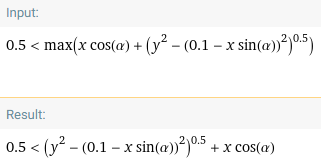

bcm

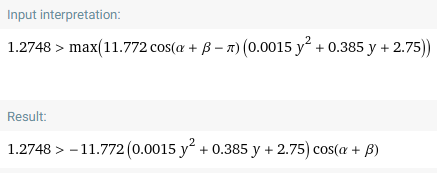

so now we have:
```
0.5<(y^2 - (0.1 - x sin(α))^2)^0.5 + x cos(α)
1.2748>-11.772 (0.0015 y^2 + 0.385 y + 2.75) cos(α + β)
```
alpha and beta can vary in the intervals [20,90] and [10,160] respectively.

We need the top equation to be true for the values of alpha and beta that maximise the rhs, and the bottom to be true for the values that minimise the rhs.

The equation `0.5<(y^2 - (0.1 - x sin(α))^2)^0.5 + x cos(α)` is maximised around where `sin(α)` is close to `0.07`, as that allows for `(0.1 - x sin(α))^2=~0` and `x cos(α)>>0`.

alpha in radians on x axis and range in meters on y axis (values for arm length arbitrary) (sin(alpha) =~ alpha):

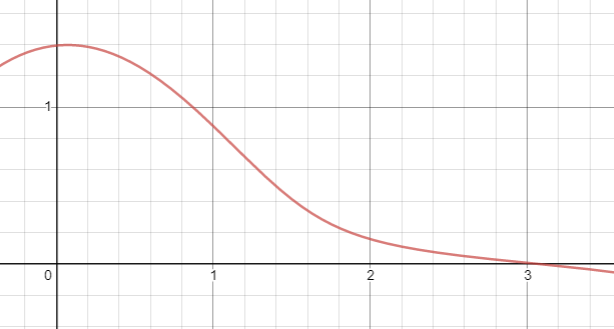

We can say that the minimun alpha in the range should be used, as this function is maximised on the smallest alpha in the interval [20,90], as it is decreasing in that interval for all reasonable values of x and y.

In hindsight, that was probably quite obvious, but it was nice to prove it anyways.
```
0.5 < (y^2 - (0.1 - xsin(20))^2)^0.5 + xcos(20)
0.5 < (y^2 - (xsin(20) - 0.1)^2)^0.5 + xcos(20)
(0.5 - xcos(20))^2 < y^2 - (xsin(20) - 0.1)^2
(0.5 - xcos(20))^2 + (xsin(20) - 0.1)^2 < y^2
y > ((0.5 - xcos(20))^2 + (xsin(20) - 0.1)^2)^0.5
y > (x^2 - 1.0081 x + 0.26)^0.5
```

The graph for the approximation does not hold well for low values of x but the graphs generally look ok for the true answers. green is approx..

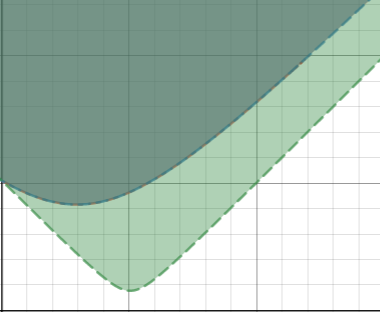

for small x (which we have as x is in meters), we could probably ignore the x^2 term, but I'll leave it in for now.

After feeling like an idiot for overlooking the obvious on the range, I'm going to start off by making some obvious observations. The equation for BCM:
```
11.772 * cos(alpha + beta - pi) * (0.0015 * y**2 + 0.385 * y + 2.75)
```
will be largest (which is worst case scenario), when `alpha + beta = 0`, so we can say:
```
max_alpha_beta(11.772 * cos(alpha + beta - pi) * (0.0015 * y**2 + 0.385 * y + 2.75))
= 11.772 * (0.0015 * y**2 + 0.385 * y + 2.75)
= 0.017658 y^2 + 4.53222 y + 32.373
=~ 0.018 y^2 + 4.533 y + 32.373 (rounded up, athough noone's losing any sleep over a one hundredth of a Nm)
```

Graphs show approximation and real values (ontop of eachother) (y axis is moment, x axis is length y):

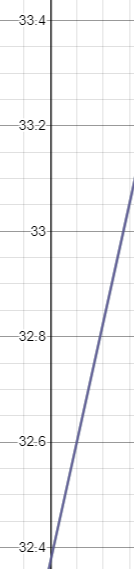

Unfortunately, I must have made some error in my initial calculations, as the moment for y = 0 should not be so large.

After checking, I have noticed that I used teh value in cm instead of in m in the calculations, so the intercept needs to be divided by 100, so:
```
2 * 1.2748 > 0.018 y^2 + 4.533 y + 0.32373  (for double servo)
y < 0.490083
```

This all assumes 2 servos on the end of the arm (one for rotation)

now we have:
```
y < 0.490083
y > (x^2 - 1.0081 x + 0.26)^0.5
```

I'm pretty sure we can use a similar method for the alpha moments, to maximise them, but I want to make sure the formula is correct first.

There are a few changes needed for the alpha moments as well. We are using 2 servos at the second hinge instead of 1 and, we will probablly have 3 or 4 at the base. I think I'll leave the servos at the base as a variable though.

This is what I had before:
```python
ALPHA_ANTICLOCKWISE_MOMENT = SERVO_TORQUE
alpha_clockwise_moments = lambda alpha, beta, x, y : 11.772 * ((x * 0.003) * (x / 2) * cos(alpha) + (0.055) * (x) \
                                                     * cos(alpha) + (y + 0.003) * ((x * sin(alpha) + y * sin(alpha + beta - pi) / 2) + (x * cos(alpha) \
                                                     + y * cos(alpha + beta - pi) / 2)**2)**0.5 * cos(atan((x * sin(alpha) + y * sin(alpha + beta -pi) / 2) \
                                                     / (x * cos(alpha) + y * cos(alpha + beta - pi) / 2))) + (0.11) * ((x * sin(alpha) + y * sin(alpha + beta - pi))**2 \
                                                     + (x * cos(alpha) + y * cos(alpha + beta - pi))**2)**0.5 * cos(atan((x * sin(alpha) + y * sin(alpha + beta - pi)) \
                                                     / (x * cos(alpha) + y * cos(alpha + beta - pi)))) + (0.275) * ((x * sin(alpha) + (y + 0.1) * sin(alpha + beta - pi))**2 \
                                                     + (x * cos(alpha) + (y + 0.1) * cos (alpha + beta - pi))**2)**0.5 * cos(atan((x * sin(alpha) + (y + 0.1) * sin(alpha \
                                                     + beta - pi)) / (x * cos(alpha) + (y + 0.1) * cos(alpha + beta - pi)))))  # could improve speed here by evaling cos(alpha, beta ... ) before
```

This also needs to be true for all `alpha` and `beta` in the range. As with before, The worst values of `alpha` and `beta` within the correct range will be `alpha = 20` and `beta = pi - 20`, so we can immediately sub these in.

The value `11.772` is for `g \* f = 9.81 \* 1.2 = 11.772`

The general layout of the function is made from this repeated component:

`11.772 \* mass \* distance \* cos(angle)`

Mistakes I have noticed:
I used 10 rather than 0.1 (cm instead of m) for the hand length

new function:
```
clockwise_moments(alpha, beta, x, y) = 11.7772 * (
  (0.003 * x) * (x / 2) * cos(alpha)
  (0.055 * 2) * (x) * cos(alpha)
  (0.003 * y) * (((x * sin(alpha) + (y/2) * sin(alpha + beta - pi))^2 + (x * cos(alpha) + (y/2) * cos(alpha + beta - pi))^2)^0.5) * cos(atan((x * sin(alpha) + (y/2) * sin(alpha + beta - pi))/(x * cos(alpha) + (y/2) * cos(alpha + beta - pi))
  (0.055 * 2) * (((x * sin(alpha) + y * sin(alpha + beta - pi))^2 + (x * cos(alpha) + y * cos(alpha + beta - pi))^2)^0.5) * cos(atan((x * sin(alpha) + y * sin(alpha + beta - pi))/(x * cos(alpha) + y * cos(alpha + beta - pi))))
  (0.275) * (((x * sin(alpha) + (y + 0.1) * sin(alpha + beta - pi))^2 + (x * cos(alpha) + (y + 0.1) * cos(alpha + beta - pi))^2)*0.5) * cos(atan((x * sin(alpha) + (y + 0.1) * sin(alpha + beta - pi))/(x * cos(alpha) + (y + 0.1) * cos(alpha + beta - pi))))
)
```

I should probably test this but I cant be bothered so I'm going to hope that is correct. I can begin by putting in the values already stated:
```
5.0992 >= 11.7772 * (
  (0.003 * x) * (x / 2) * cos(20)
  (0.055 * 2) * (x) * cos(20)
  (0.003 * y) * (((x * sin(20))^2 + (x * cos(20) + (y/2))^2)^0.5) * cos(atan((x * sin(20)/(x * cos(20) + (y/2))
  (0.055 * 2) * (((x * sin(20))^2 + (x * cos(20) + y)^2)^0.5) * cos(atan((x * sin(20))/(x * cos(20) + y)))
  (0.275) * (((x * sin(20))^2 + (x * cos(20) + (y + 0.1))^2)*0.5) * cos(atan((x * sin(20))/(x * cos(20) + (y + 0.1))))
)
```
(using 4 sesrvos here; angles in degrees)